# Multi-Task Learning (MTL) Basics Tutorial

Multi-task learning is becoming a standard tool for the modern ML practioner.
(See Sebastian Ruder's [survey](http://ruder.io/multi-task/) from 2017 for a nice overview).
It often leads to computational gains (one model performing many tasks takes up less memory and storage) as well as performance gains (learning to do well on a related _auxiliary_ task can improve the model's ability on the _primary_ task).
A major requirement of multi-task learning in general is the ability to easily *add new datasets, label sets, tasks, and metrics* (and just as easily remove them). Thus, in the Snorkel multi-task model design, each of these concepts have been decoupled.

The purpose of this tutorial is to introduce the basic interfaces and flow of the multi-task learning tools within Snorkel (we assume that you have prior experience with MTL, so we don't motivate or explain multi-task learning at large here).

In this notebook, we'll look at a simple MTL model with only two tasks, each having distinct data and only one set of ground truth labels ("gold" labels). We'll also use data where the raw data is directly usable as features, for simplicity (i.e., unlike text data, where we would first need to tokenize and transform the data into token ids).
At the end, you'll fill in the missing details to add a third task to the model.

## Environment Setup

In [1]:
%matplotlib inline

from snorkel.utils import set_seed

SEED = 123
set_seed(SEED)

## Create Toy Data

We'll now create a toy dataset to work with.
Our data points are 2D points in a square centered on the origin.
Our tasks will be classifying whether these points are:

1. Inside a **unit circle** centered on the origin (0 = False, 1 = True)
2. Inside a **unit square** centered on the origin (0 = False, 1 = True)

We'll visualize these decision boundaries in a few cells.

_Note: In this toy example, we don't expect these specific tasks to help the model improve on the other task, but this is often a benefit of joint training in MTL settings._

In [2]:
import os

# Make sure we're running from the spam/ directory
if os.path.basename(os.getcwd()) == "snorkel-tutorials":
    os.chdir("multitask")

In [3]:
from utils import make_circle_data, make_square_data

N = 1000  # Data points per dataset
R = 1  # Unit distance

circle_data_splits, circle_label_splits = make_circle_data(N, R)
square_data_splits, square_label_splits = make_square_data(N, R)

In [4]:
print(f"Data splits: {list(circle_data_splits.keys())}")
print(f"Training data shape: {circle_data_splits['train'].shape}")
print(f"Label space: {set(circle_label_splits['train'])}")

Data splits: ['train', 'valid', 'test']
Training data shape: (800, 2)
Label space: {0, 1}


And we can view the ground truth labels of our tasks visually to confirm our intuition on what the decision boundaries look like.
These two datasets occupy the same region in Euclidean space, but are disjoint sets of data points.
In the plots below, the purple points represent class 0 and the yellow points represent class 1.

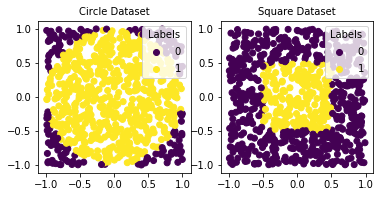

In [5]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)

scatter = axs[0].scatter(
    circle_data_splits["train"][:, 0],
    circle_data_splits["train"][:, 1],
    c=circle_label_splits["train"],
)
axs[0].set_aspect("equal", "box")
axs[0].set_title("Circle Dataset", fontsize=10)
axs[0].legend(*scatter.legend_elements(), loc="upper right", title="Labels")

scatter = axs[1].scatter(
    square_data_splits["train"][:, 0],
    square_data_splits["train"][:, 1],
    c=square_label_splits["train"],
)
axs[1].set_aspect("equal", "box")
axs[1].set_title("Square Dataset", fontsize=10)
axs[1].legend(*scatter.legend_elements(), loc="upper right", title="Labels")

plt.show()

Note that, as is the case throughout the Snorkel repo, all ground truth labels have non-negative integer values: 0, 1, 2, etc. **The label -1 is reserved for abstaining/no label.** This ability to abstain provides flexibility for supervision sources to label only portions of a dataset (abstaining on the rest), for example.

## Make DataLoaders

With our data now loaded/created, we can now package it up into `DictDataset`s for training. This object is a simple wrapper around `torch.utils.data.Dataset` and stores data fields and labels as dictionaries.

In the `DictDataset`, each label corresponds to a particular `Task` by name.  We'll define these `Task` objects in the following section as we define our model.

`DictDataloader` is a wrapper for `torch.utils.data.Dataloader`, which handles the collate function for `DictDataset` appropriately.

In [6]:
import torch
from snorkel.classification import DictDataset, DictDataLoader

dataloaders = []
for split in ["train", "valid", "test"]:
    X_dict = {"circle_data": torch.FloatTensor(circle_data_splits[split])}
    Y_dict = {"circle_task": torch.LongTensor(circle_label_splits[split])}
    dataset = DictDataset("CircleDataset", split, X_dict, Y_dict)
    dataloader = DictDataLoader(dataset, batch_size=32)
    dataloaders.append(dataloader)

for split in ["train", "valid", "test"]:
    X_dict = {"square_data": torch.FloatTensor(square_data_splits[split])}
    Y_dict = {"square_task": torch.LongTensor(square_label_splits[split])}
    dataset = DictDataset("SquareDataset", split, X_dict, Y_dict)
    dataloader = DictDataLoader(dataset, batch_size=32)
    dataloaders.append(dataloader)

We now have 6 data loaders, one for each task (`circle_task` and `square_task`) for each split (`train`, `valid`, `test`).

## Define Model

Now we'll define the `MultitaskClassifier`, a flexible multi-task classifier written in PyTorch that is built from a list of `Tasks`.

### Tasks

A `Task` represents a path through a neural network. In `MultitaskClassifier`, this path corresponds to a particular sequence of PyTorch modules through which each example will make a forward pass.

To specify this sequence of modules, each `Task` defines a **module pool** (a set of modules that it relies on) and a **task flow**—a sequence of `Operation`s. Each `Operation` defines a module and the inputs to feed to that module. These inputs are described with a list of tuples, where each tuple has the name of a previous operation (or the keyword `_input_` to denote the original input) and either the name of a field (e.g., if the output of that operation is a `dict`) or an index (e.g., if the output of that operation is a `list` or `tuple`). Most PyTorch modules output a single tensor, so most of the time, the second element of this tuple is 0.

As an example, below we define the module pool and task flow for the circle task:

In [7]:
import torch.nn as nn
from snorkel.classification import Operation

# Define a two-layer MLP module and a one-layer prediction "head" module
base_mlp = nn.Sequential(nn.Linear(2, 8), nn.ReLU(), nn.Linear(8, 4), nn.ReLU())
head_module = nn.Linear(4, 2)

# The module pool contains all the modules this task uses
module_pool = nn.ModuleDict({"base_mlp": base_mlp, "circle_head_module": head_module})

# "From the input dictionary, pull out 'circle_data' and send it through input_module"
op1 = Operation(
    name="base_mlp", module_name="base_mlp", inputs=[("_input_", "circle_data")]
)

# "From the output of op1 (the input op), pull out the 0th indexed output
# (i.e., the only output) and send it through the head_module"
op2 = Operation(
    name="circle_head", module_name="circle_head_module", inputs=[("base_mlp", 0)]
)

task_flow = [op1, op2]

A dictionary containing the outputs of all operations will then go into a `loss_func()` to calculate the loss (e.g., cross-entropy) during training or an `output_func()` (e.g., softmax) to convert the logits into a prediction.
Both of these functions accept as an argument the name of the operation whose output they should use to calculate their respective values; in this case, that will be the `circle_head` operation.
We indicate that here with the `partial` helper method, which can set the value of that keyword argument before the function is actually called.
(As you'll see below, for common classification tasks, the default values for these arguments often suffice).

Each `Task` also specifies which metrics it supports, which are bundled together in a `Scorer` object. For this tutorial, we'll just look at accuracy.

Putting this all together, we define the circle task:

In [8]:
from functools import partial

from snorkel.classification import Scorer, Task, ce_loss, softmax

circle_task = Task(
    name="circle_task",
    module_pool=module_pool,
    task_flow=task_flow,
    loss_func=partial(ce_loss, op_name="circle_head"),
    output_func=partial(softmax, op_name="circle_head"),
    scorer=Scorer(metrics=["accuracy"]),
)

Note that `Task` objects are not dependent on a particular dataset; multiple datasets can be passed through the same modules for pre-training or co-training.

We'll now define the square task, but more succinctly—for example, using the fact that the default name for an `Operation` is its `module_name` (since most tasks only use their modules once per forward pass).

We'll also define the square task to share the first module in its task flow (`base_mlp`) with the circle task to demonstrate how to share modules. (Note that this is purely for illustrative purposes; for this toy task, it is very possible that this is not the optimal arrangement of modules).

Finally, the most common task definitions we see in practice are classification tasks with cross-entropy loss and softmax on the output of the last module, and accuracy is most often the primary metric of interest, these are all the default values, so we can drop them here for brevity.

In [9]:
square_task = Task(
    name="square_task",
    module_pool=nn.ModuleDict({"base_mlp": base_mlp, "square_head": nn.Linear(4, 2)}),
    task_flow=[
        Operation("base_mlp", [("_input_", "square_data")]),
        Operation("square_head", [("base_mlp", 0)]),
    ],
)

## Model

With our tasks defined, constructing a model is simple: we simply pass the list of tasks in and the model constructs itself using information from the task flows.

Note that the model uses the names of modules (not the modules themselves) to determine whether two modules specified by separate tasks are the same module (and should share weights) or different modules (with separate weights).
So because both the `square_task` and `circle_task` include "base_mlp" in their module pools, this module will be shared between the two tasks.

In [10]:
from snorkel.classification import MultitaskClassifier

model = MultitaskClassifier([circle_task, square_task])

### Train Model

Once the model is constructed, we can train it as we would a single-task model, using the `fit` method of a `Trainer` object. The `Trainer` supports multiple schedules or patterns for sampling from different dataloaders; the default is to randomly sample from them proportional to their number of batches, such that all examples  will be seen exactly once before any are seen twice.

In [11]:
from snorkel.classification.training import Trainer

trainer_config = {"progress_bar": False, "n_epochs": 10, "lr": 0.02}

trainer = Trainer(**trainer_config)
trainer.fit(model, dataloaders)

### Evaluate model

After training, we can call the model.score() method to see the final performance of our trained model.

In [12]:
model.score(dataloaders)

{'circle_task/CircleDataset/train/accuracy': 0.91875,
 'circle_task/CircleDataset/valid/accuracy': 0.93,
 'circle_task/CircleDataset/test/accuracy': 0.93,
 'square_task/SquareDataset/train/accuracy': 0.9525,
 'square_task/SquareDataset/valid/accuracy': 0.97,
 'square_task/SquareDataset/test/accuracy': 0.96}

Task-specific metrics are recorded in the form `task/dataset/split/metric` corresponding to the task the made the predictions, the dataset the predictions were made on, the split being evaluated, and the metric being calculated.

For model-wide metrics (such as the total loss over all tasks or the learning rate), the default task name is `model` and the dataset name is `all` (e.g. `model/all/train/loss`).

# Your Turn

To check your understanding of how to use the multi-task `MultitaskClassifier`, see if you can add a task to this multi-task model.

We'll generate the data for you (again, with a train, valid, and test split).
Let's call it the `inv_circle_task`, since it will have the same distribution as our circle data, but with the inverted (flipped) labels.
Intuitively, a model that is very good at telling whether a point is within a certain region should also be very good at telling if it's outside the region.

By sharing some layers (the `base_mlp`), this new task will help the model to learn a representation that benefits the `circle_task` as well.
And because it will have a non-shared layer (call it the `inv_circle_head`), it will have the flexibility to map that good representation into the right label space for its own task.

### Create the data

In [13]:
from utils import make_inv_circle_data

# We flip the inequality when generating the labels so that our positive class is now _outside_ the circle.
inv_circle_data_splits, inv_circle_label_splits = make_inv_circle_data(N, R)

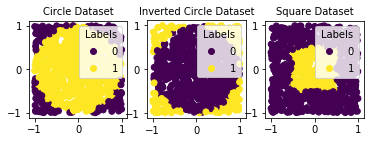

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3)

scatter = axs[0].scatter(
    circle_data_splits["train"][:, 0],
    circle_data_splits["train"][:, 1],
    c=circle_label_splits["train"],
)
axs[0].set_aspect("equal", "box")
axs[0].set_title("Circle Dataset", fontsize=10)
axs[0].legend(*scatter.legend_elements(), loc="upper right", title="Labels")

scatter = axs[1].scatter(
    inv_circle_data_splits["train"][:, 0],
    inv_circle_data_splits["train"][:, 1],
    c=inv_circle_label_splits["train"],
)
axs[1].set_aspect("equal", "box")
axs[1].set_title("Inverted Circle Dataset", fontsize=10)
axs[1].legend(*scatter.legend_elements(), loc="upper right", title="Labels")

scatter = axs[2].scatter(
    square_data_splits["train"][:, 0],
    square_data_splits["train"][:, 1],
    c=square_label_splits["train"],
)
axs[2].set_aspect("equal", "box")
axs[2].set_title("Square Dataset", fontsize=10)
axs[2].legend(*scatter.legend_elements(), loc="upper right", title="Labels")

plt.show()

### Create the DictDataLoader

Create the `DictDataLoader` for this new dataset.
- The X_dict should map data field names to data (in this case, we only need one field, since our data is represented by a single Tensor). You can name the field whatever you want; you'll just need to make sure that your `Task` object refers to the right field name in its task flow.
- The Y_dict should map a task name to a set of labels. This will tell the model what path through the network to use when making predictions or calculating loss on batches from this dataset. At this point we haven't yet defined our

In [15]:
X_dict = {}  # Update this line
Y_dict = {}  # Update this line
inv_dataset = DictDataset("InvCircleDataset", "train", X_dict, Y_dict)
inv_dataloader = DictDataLoader(dataset=inv_dataset, batch_size=32)

We add this new dataloader to the dataloaders for the other tasks.

In [16]:
all_dataloaders = dataloaders + [inv_dataloader]

### Create the task

Using the `square_task` definition as a template, fill in the arguments for an `inverse_circle_task` that consists of the same `base_mlp` module as the other tasks and a separate linear head with an output of size 2.

In [17]:
# Uncomment and fill in the arguments to creat a Task object for the inverse_circle task.
# inv_circle_task = Task(
#     name="",  # Update this line
#     module_pool=nn.ModuleDict({}),  # Update this line
#     task_flow=[],  # Update this line
# )

### Create the model

Once we have our task objects, creating the new multi-task model is as easy as adding the new task to the list of tasks at model initialization time.

In [18]:
# Add your new task to the list of tasks for creating the MTL model
model = MultitaskClassifier([circle_task, square_task])  # Update this line

### Train the model

We can use the same trainer and training settings as before.

In [19]:
trainer.fit(model, all_dataloaders)
model.score(all_dataloaders)

{'circle_task/CircleDataset/train/accuracy': 0.93875,
 'circle_task/CircleDataset/valid/accuracy': 0.95,
 'circle_task/CircleDataset/test/accuracy': 0.94,
 'square_task/SquareDataset/train/accuracy': 0.95625,
 'square_task/SquareDataset/valid/accuracy': 0.97,
 'square_task/SquareDataset/test/accuracy': 0.96}

### Validation

If you successfully added the appropriate task, the previous command should have succesfully trained and reported scores in the mid to high 90s for all datasets and splits, including for the splits belonging to the new `inv_circle_task`.
The following assert statements should also pass if you uncomment and run it.

In [20]:
# assert len(model.tasks) == 3
# assert len(model.module_pool) == 4  # 1 shared module plus 3 separate task heads

## Summary

In this tutorial, we demonstrated how to specify arbitrary flows through a network with  multiple datasets, providing the flexiblity to easily implement design patterns such as multi-task learning. On this toy task with only two simple datasets and very simple hard parameter sharing (a shared trunk with different heads), the utility of this design may be less apparent. However, for more complicated network structures (e.g., slicing) or scenarios with frequent changing of the structure (e.g., due to popping new tasks on/off a massive MTL model), the flexibility of this design starts to shine. If there's an MTL network you'd like to build but can't figure out how to represent, post an issue and let us know!